In [1]:
# this notebook follows on from mlpy_2d_spc.ipynb which demonstrates how to read in NMRPipe processed
# 2D spectra etc.
# in this notebook automated multiplet picking in 2D HSQC spectra for tracer base metabolism
# is demonstrated
# the file is saved after peak picking, so that the results can be inspected in
# MetaboLabPy GUI
#
# import packages
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
import math
import scipy as sp
from scipy import optimize
%matplotlib notebook
from jupyterthemes import jtplot
jtplot.style()
from sklearn.decomposition import FastICA, PCA
from metabolabpy.nmr import nmrDataSet
from metabolabpy.nmr import hsqcData
import os
# please change download directory if Downloads is not in the user's home folder
download_dir = os.path.join(os.path.expanduser('~'), "Downloads")
file_name = os.path.join(download_dir, "sample_2d_spc.mlpy")
# create and load NmrDataSet
nd = nmrDataSet.NmrDataSet()
nd.load(file_name)

# set basic variables
range_h = 0.1
range_c = 1.0

metabolites = ['L-Alanine', 'L-AsparticAcid', 'L-GlutamicAcid', 'L-LacticAcid']

for m in metabolites:
    print(m)
    # set metabolite and peak
    metabolite_name = m
    spin_number = 1
    cur_peak = spin_number
    nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name] = hsqcData.HsqcData() # empty hsqc_data for chosen metabolite
    nd.nmrdat[0][0].hsqc.read_metabolite_information(metabolite_name)
    nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].init_data(nd.nmrdat[0][0].hsqc.metabolite_information)
    nd.nmrdat[0][0].hsqc.cur_metabolite = metabolite_name
    nd.nmrdat[0][0].hsqc.read_metabolite_information(metabolite_name)
    nd.nmrdat[0][0].hsqc.set_metabolite_information(metabolite_name, nd.nmrdat[0][0].hsqc.metabolite_information)
    nd.nmrdat[0][0].hsqc.cur_peak = cur_peak
    nd.nmrdat[0][0].hsqc.set_peak_information()
    for kk in range(len(nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].h1_shifts)):
        spin_number = kk + 1
        cur_peak = spin_number
        #print(cur_peak)
        nd.nmrdat[0][0].hsqc.cur_peak = cur_peak
        nd.nmrdat[0][0].hsqc.set_metabolite_information(metabolite_name, nd.nmrdat[0][0].hsqc.metabolite_information)
        nd.nmrdat[0][0].hsqc.set_peak_information()
        nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].c13_picked[cur_peak - 1] = nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].spin_systems[cur_peak - 1]['c13_shifts'][0]
        # 25% contribution for every multiplet component
        cont = np.copy(nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].spin_systems[cur_peak - 1]['contribution'])
        cnt = np.array([80, 100, 100, 50]) #[100, 50, 50, 25])
        cnt = np.copy(cnt[range(len(cont))])
        cnt =cnt / np.sum(cnt)
        cnt *= 100
        nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].spin_systems[cur_peak - 1]['contribution'] = cnt
        # sim 1d 13C spectrum in library shift position
        nd.nmrdat[0][0].sim_hsqc_1d()
        # determine spectral area to be used
        hd = nd.nmrdat[nd.s][nd.e].hsqc.hsqc_data[metabolite_name]
        h1_centre = hd.h1_shifts[spin_number -1]
        c13_centre = hd.c13_shifts[hd.h1_index[spin_number - 1] - 1]
        h1_suffix = hd.h1_suffix[spin_number - 1]
        scale = nd.nmrdat[nd.s][nd.e].hsqc.j_scale
        hsqc_idx = np.where(hd.hsqc == 1)[0]
        h1_index = hd.h1_index[spin_number - 1]
        c13_index = hd.c13_index[hd.h1_index[spin_number - 1] - 1]
        h1_beg = h1_centre + range_h
        h1_end = h1_centre - range_h
        c13_beg = c13_centre + range_c*scale
        c13_end = c13_centre - range_c*scale
        h1_pts = len(nd.nmrdat[nd.s][nd.e].spc[0])
        c13_pts = len(nd.nmrdat[nd.s][nd.e].spc)
        h1_pts1 = h1_pts - nd.nmrdat[nd.s][nd.e].ppm2points(h1_beg, 0) - 1
        h1_pts2 = h1_pts - nd.nmrdat[nd.s][nd.e].ppm2points(h1_end, 0) - 1
        c13_pts2 = c13_pts - nd.nmrdat[nd.s][nd.e].ppm2points(c13_beg, 1) - 1
        c13_pts1 = c13_pts - nd.nmrdat[nd.s][nd.e].ppm2points(c13_end, 1) - 1
        # set display parameters
        d = nd.nmrdat[nd.s][nd.e].display
        if d.pos_col == "RGB":
            pos_col = d.pos_col_rgb
        else:
            pos_col = d.pos_col
        
        if d.neg_col == "RGB":
            neg_col = d.neg_col_rgb
        else:
            neg_col = d.neg_col
        
        pos_col = matplotlib.colors.to_hex(pos_col)
        neg_col = matplotlib.colors.to_hex(neg_col)
        xlabel = d.x_label + " C" + str(c13_index) + "H" + str(h1_index) + h1_suffix + " [" + d.axis_type1 + "]"
        ylabel = d.y_label + " C" + str(c13_index) + "H" + str(h1_index) + h1_suffix + " [" + d.axis_type2 + "]"
        mm = np.max(np.abs(nd.nmrdat[nd.s][nd.e].spc.real))
        pos_lev = np.linspace(d.min_level * mm, d.max_level * mm, d.n_levels)
        neg_lev = np.linspace(-d.max_level * mm, -d.min_level * mm, d.n_levels)
        spc = nd.nmrdat[nd.s][nd.e].spc[c13_pts1:c13_pts2, h1_pts1:h1_pts2].real
        c13_centre_pts = round(np.median(np.linspace(c13_pts1,c13_pts2, np.abs(c13_pts2 - c13_pts1) + 1, dtype=int)))
        h1_centre_pts = round(np.median(np.linspace(h1_pts1,h1_pts2, np.abs(h1_pts2 - h1_pts1) + 1, dtype=int)))
        # define custom G function used in the approximation to neg entropy 
        def my_g(x):
            return x**2, 2*x
        
        # set FastICA parameters, execute ICA and get estimated mixing matrix (A_)
        n_comp = 9
        ica = FastICA(n_components=n_comp, algorithm='deflation', whiten='arbitrary-variance', fun=my_g) #, fun=my_g)
        S_ = ica.fit_transform(np.transpose(spc / np.max(spc)))  # Reconstruct signals
        A_ = ica.mixing_  
        n_rows = round(math.sqrt(n_comp))
        n_cols = math.ceil(n_comp / n_rows)
        ica = np.transpose(A_)
        data = np.transpose(spc / np.max(spc))
        spc2 = nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].sim_spc[cur_peak - 1][c13_pts1:c13_pts2]
        spc2 /= np.linalg.norm(spc2)
        max_shift = int(len(spc2) / 2) - 1
        corr2 = np.zeros((len(ica), 2*max_shift + 1))
        shift2 = np.zeros((len(ica), 2*max_shift + 1), dtype=int)
        corr_max = np.zeros(len(ica))
        idx_max = np.zeros(len(ica), dtype=int)
        shift_max = np.zeros(len(ica), dtype=int)
        # correlate ica and shifted simulated spectrum in 13C dimension
        for l in range(len(ica)):
            for k in range(2 * max_shift+1):
                corr2[l][k] = np.corrcoef(ica[l], np.roll(spc2, k - max_shift))[0][1]
                shift2[l][k] = int(k - max_shift)
        
            idx_max[l] = int(np.where(corr2[l] == np.max(corr2[l]))[0][0])
            corr_max[l] = np.max(corr2[l])
            shift_max[l] = shift2[l][idx_max[l]]
        
        spc2_idx = np.where(corr_max == np.max(corr_max))[0][0]
        spc3 = np.roll(spc2, shift_max[spc2_idx])
        # correlate 13C shifted, simulated spectrum across different 1H shift area
        corr3 = np.zeros(len(data))
        for l in range(len(data)):
            corr3[l] = np.corrcoef(data[l], spc3)[0][1]
        
        max_idx3 = np.where(corr3 == np.max(corr3))[0][0]
        h1_pts_f = h1_pts1 + max_idx3 - 1
        c13_pts_f = c13_pts1 + max_shift + shift_max[spc2_idx] + 1
        h1_shift = nd.nmrdat[0][0].points2ppm(len(nd.nmrdat[0][0].spc[0]) - h1_pts_f, 0)
        c13_shift = nd.nmrdat[0][0].points2ppm(len(nd.nmrdat[0][0].spc) - c13_pts_f, 1)
        local_opt = nd.nmrdat[0][0].pick_local_opt([h1_shift, c13_shift])
        nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].c13_picked[cur_peak - 1] = [local_opt[1]]
        nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].h1_picked[cur_peak - 1] = [local_opt[0]]
        cont = np.copy(nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].spin_systems[cur_peak - 1]['contribution'])
        nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].spin_systems[cur_peak - 1]['contribution'] = np.zeros(len(cont)) 
        nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].spin_systems[cur_peak - 1]['contribution'][0] = 100
        nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].sim_spc[cur_peak - 1] = []

nd.save(file_name)
print("finished")

L-Alanine
L-AsparticAcid
L-GlutamicAcid
L-LacticAcid
finished


<IPython.core.display.Javascript object>


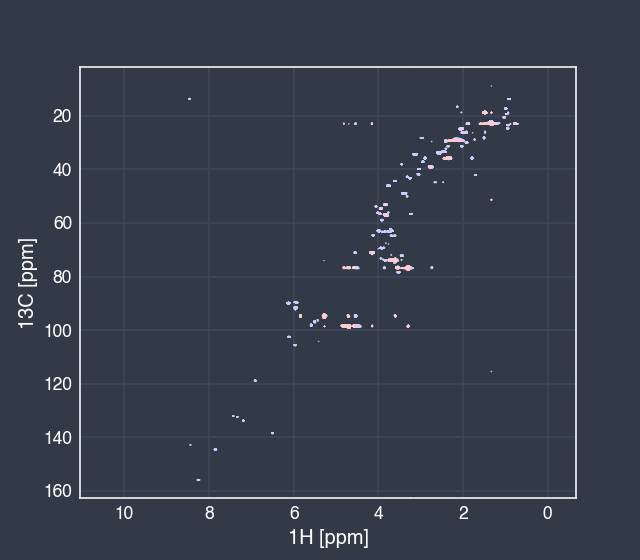

In [2]:
nd.plot_spc()

<IPython.core.display.Javascript object>


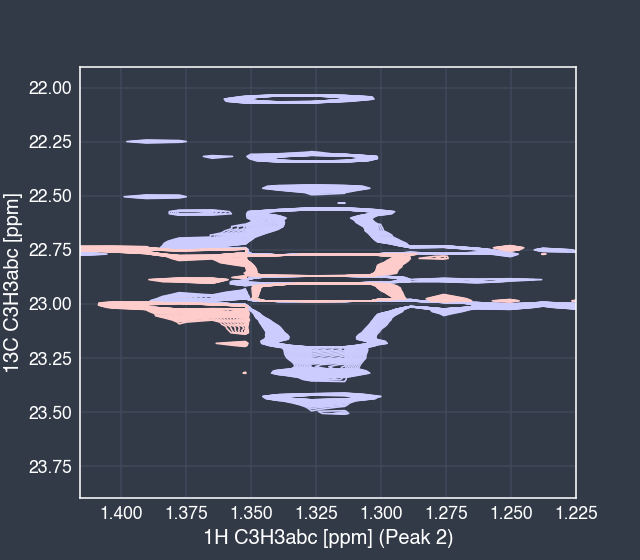

In [3]:
pl.contour(nd.nmrdat[nd.s][nd.e].ppm1[h1_pts1:h1_pts2],
           nd.nmrdat[nd.s][nd.e].ppm2[c13_pts1:c13_pts2],
           spc,
           pos_lev, colors=pos_col,linestyles='solid', antialiased=True)
pl.contour(nd.nmrdat[nd.s][nd.e].ppm1[h1_pts1:h1_pts2],
           nd.nmrdat[nd.s][nd.e].ppm2[c13_pts1:c13_pts2],
           spc,
           neg_lev, colors=neg_col,linestyles='solid', antialiased=True)
if nd.cf.mode == 'dark':
    bg = (50 / 255, 58 / 255, 72 / 255)
    fg = (255 / 255, 255 / 255, 255 / 255)
    pl.gcf().set_facecolor(bg)
    pl.gca().set_facecolor(bg)
    pl.gca().xaxis.label.set_color(fg)
    pl.gca().yaxis.label.set_color(fg)
    pl.gca().tick_params(axis='x', colors=fg)
    pl.gca().tick_params(axis='y', colors=fg)
    pl.gca().spines['bottom'].set_color(fg)
    pl.gca().spines['top'].set_color(fg)
    pl.gca().spines['left'].set_color(fg)
    pl.gca().spines['right'].set_color(fg)
    
xlabel += " (Peak {})".format(spin_number)
pl.gca().set_xlabel(xlabel)
pl.gca().set_ylabel(ylabel)
pl.gca().invert_xaxis()
pl.gca().invert_yaxis()
pl.show()

<IPython.core.display.Javascript object>


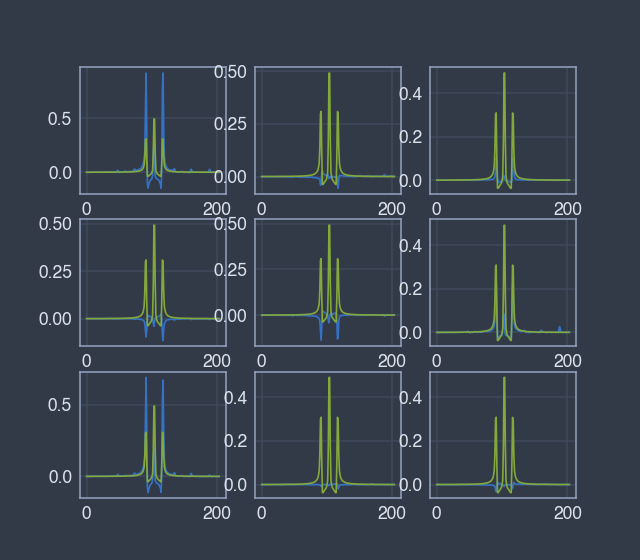

In [4]:
for k in range(n_comp):
    pl.subplot(n_rows,n_cols,k+1)
    pl.plot(np.transpose(A_)[k])
    pl.plot(spc3)


<IPython.core.display.Javascript object>


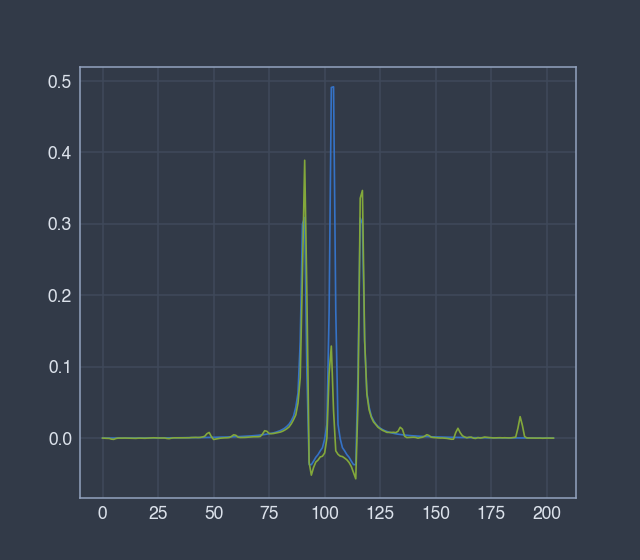

6

In [5]:
pl.plot(spc3)
pl.plot(data[max_idx3])
max_idx3

<IPython.core.display.Javascript object>


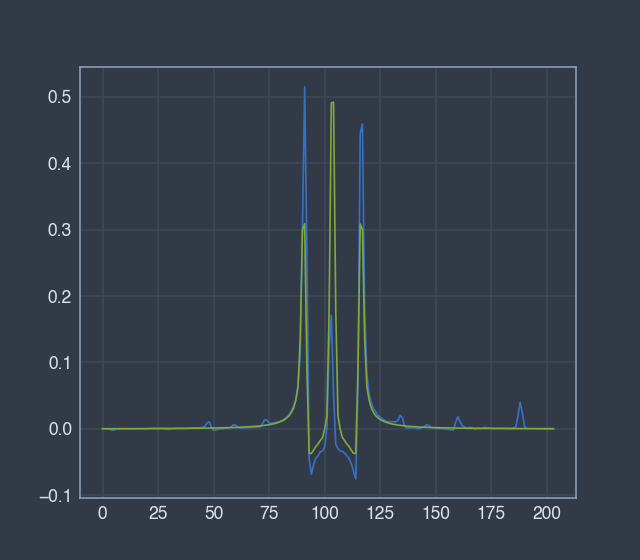

In [6]:
pl.plot(data[max_idx3] / np.linalg.norm(data[max_idx3]))
pl.plot(spc3 / np.linalg.norm(spc3))

In [7]:
h1_shift = nd.nmrdat[0][0].points2ppm(len(nd.nmrdat[0][0].spc[0]) - (h1_pts1 + max_idx3 - 1), 0)
c13_shift = nd.nmrdat[0][0].points2ppm(len(nd.nmrdat[0][0].spc) - (c13_pts1 + max_shift + shift_max[spc2_idx] + 1), 1)
print("1H shift: {}, 13C shift: {}".format(h1_shift, c13_shift))

1H shift: 1.3649065864223586, 13C shift: 22.8972


In [8]:
nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].c13_picked[cur_peak - 1] = [c13_shift]
nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].h1_picked[cur_peak - 1] = [h1_shift]
cont = np.copy(nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].spin_systems[cur_peak - 1]['contribution'])
nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].spin_systems[cur_peak - 1]['contribution'] = np.zeros(len(cont)) 
nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].spin_systems[cur_peak - 1]['contribution'] = 100
nd.nmrdat[0][0].hsqc.hsqc_data[metabolite_name].sim_spc[cur_peak - 1] = []